In [1]:
import pooch


url = f"https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_and_wind.nc4",
    known_hash="sha256:f3c5fd95ccffb9baea40aa431f6e0946cb2f49ea07274083e5d704e8099ea4c6",
)

In [2]:
import cf_xarray
import xarray as xr


ds = xr.open_dataset(fname)

In [3]:
# adp location
lon, lat = -48.401215, -27.253183

In [4]:
import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


m = find_nearest(ds["m"], lon)
n = find_nearest(ds["n"], lat)
serie = ds.isel(m=m, n=n)

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(4, 4), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        }
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="10m")
    return fig, ax

In [6]:
import numpy as np


bbox = ds["m"].min(), ds["m"].max(), ds["n"].min(), ds["n"].max()
bbox = [v.to_numpy() for v in bbox]

x, y = np.meshgrid(ds["m"], ds["n"])

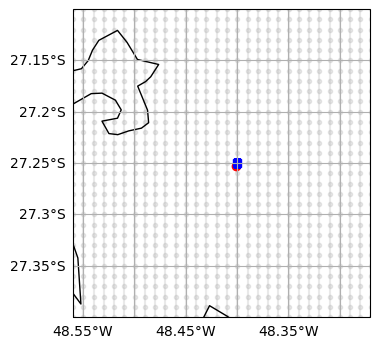

In [7]:
# %matplotlib notebook

fig, ax = creat_map(bbox=bbox)

kw = {"marker": ".", "linestyle": "-", "alpha": 0.25, "color": "darkgray"}
ax.plot(x, y, **kw, zorder=0);
ax.plot(lon, lat, "ro")
ax.plot(serie["longitude"], serie["latitude"], "bs")

ax.set_extent([-48.56, -48.27, -27.4, -27.1])

In [8]:
import utide


time = serie["time"].to_numpy()
u, v = serie["velocity_x"].to_numpy(), serie["velocity_y"].to_numpy()


coef = utide.solve(
    time,
    u, v,
    lat=-27.253183,
    method="robust",
    conf_int="MC",
    verbose=False,
)

In [9]:
import pandas as pd


def make_table_uv(coef):
    summary = pd.DataFrame(coef["diagn"])
    summary["frq"] = coef["aux"]["frq"]
    summary["Lsmaj"] = coef["Lsmaj"]
    summary["Lsmaj_ci"] = coef["Lsmaj_ci"]
    summary["Lsmin"] = coef["Lsmin"]
    summary["Lsmin_ci"] = coef["Lsmin_ci"]
    summary["theta"] = coef["theta"]
    summary["theta_ci"] = coef["theta_ci"]
    summary["g"] = coef["g"]
    summary["g_ci"] = coef["g_ci"]
    summary = summary.set_index("name")
    return summary.sort_values(by="Lsmaj", ascending=False)


summary = make_table_uv(coef)

In [10]:
summary.head(10)

,PE,SNR,frq,Lsmaj,Lsmaj_ci,Lsmin,Lsmin_ci,theta,theta_ci,g,g_ci
name,,,,,,,,,,,
SA,55.197713,488.117208,0.000114,0.116108,0.006277,0.004272,0.008176,114.584496,4.666057,161.018961,4.586026
M2,18.147801,9768.392625,0.080511,0.065312,0.000663,0.013136,0.001143,141.833229,0.933657,79.260173,0.654055
S2,5.755530,3229.290840,0.083333,0.036950,0.000611,0.006503,0.001141,145.876849,1.815445,79.009772,1.069515
S1,3.905182,452.613949,0.041667,0.030740,0.002368,0.003180,0.001580,37.449872,2.964689,226.046599,4.340489
SSA,3.590754,18.367632,0.000228,0.029361,0.006110,0.004010,0.012097,129.303004,20.032192,207.536165,14.028798
MSM,2.421643,17.797117,0.001310,0.024325,0.007866,-0.000746,0.008122,123.891724,23.605475,26.556954,14.593352
O1,2.264713,279.224612,0.038731,0.023534,0.001855,-0.000018,0.002045,169.581449,4.459413,55.689632,5.519789
MM,1.148506,9.474710,0.001512,0.016523,0.005761,-0.002804,0.008983,134.413035,37.166277,115.792294,25.665561
K1,0.880633,103.896868,0.041781,0.014674,0.002122,-0.000179,0.001860,169.995452,7.085138,72.576381,8.715037


In [11]:
from utide import reconstruct


tide = reconstruct(time, coef)

prep/calcs ... done.


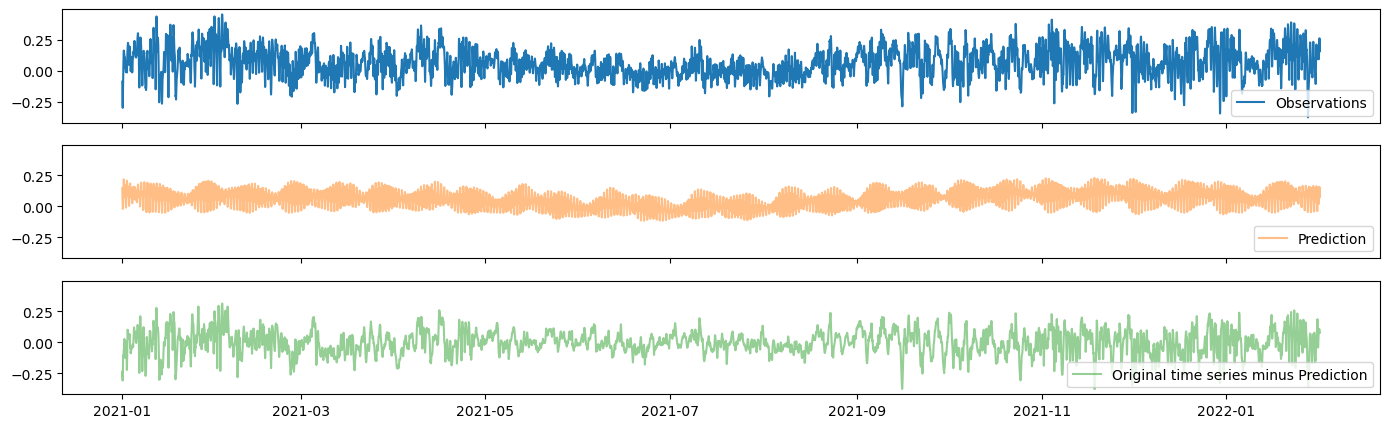

In [12]:
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, u, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["u"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, u-tide["u"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

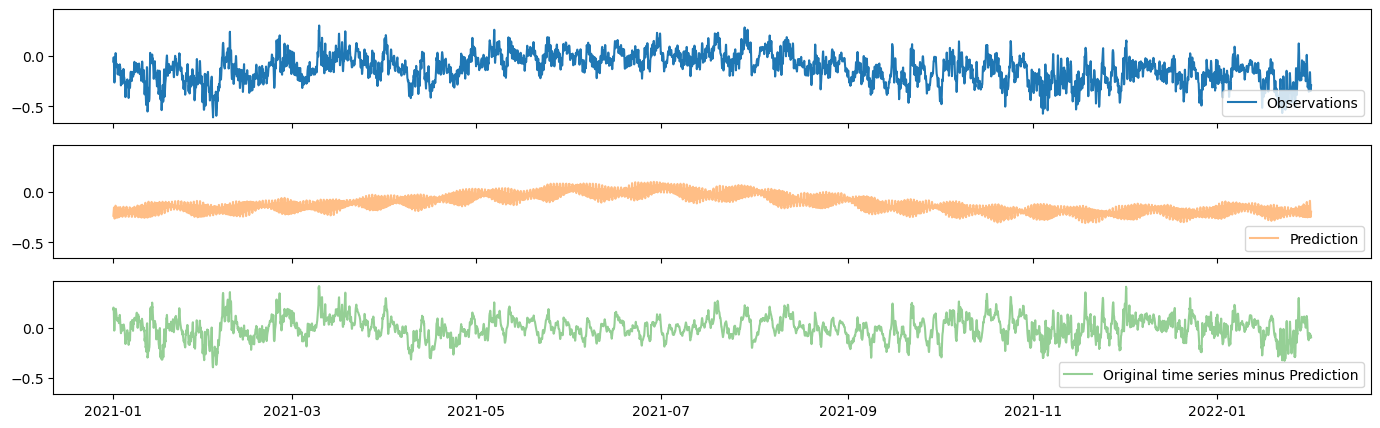

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(17, 5))

ax0.plot(time, v, label="Observations", color="C0")
ax0.legend(numpoints=1, loc="lower right")

ax1.plot(time, tide["v"], alpha=0.5, label="Prediction", color="C1")
ax1.legend(numpoints=1, loc="lower right")

ax2.plot(time, v-tide["v"], alpha=0.5, label="Original time series minus Prediction", color="C2")
ax2.legend(numpoints=1, loc="lower right");

In [14]:
import tidal_ellipse


def plot_ellipse(comp):
    const = summary.loc[comp]

    SEMA, SEMI = const["Lsmaj"], const["Lsmin"]
    PHA, INC = const["g"], const["theta"]
    ECC = SEMI / SEMA

    tidal_ellipse.do_the_plot(SEMA, ECC, INC, PHA)

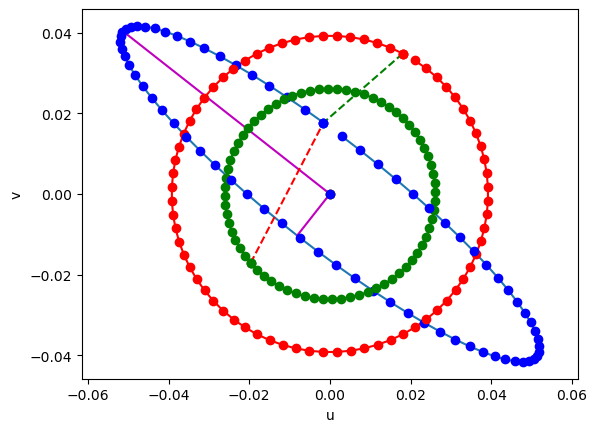

In [15]:
plot_ellipse("M2")

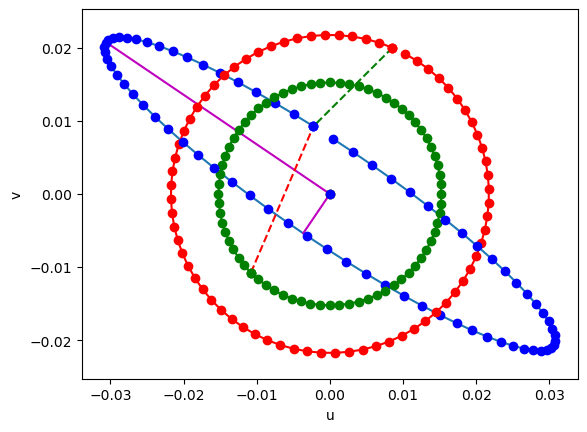

In [16]:
plot_ellipse("S2")

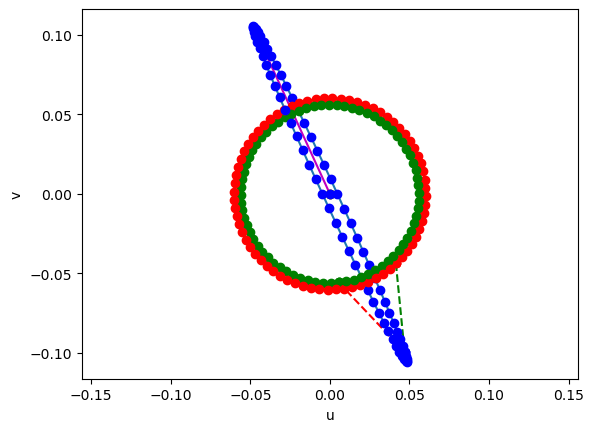

In [17]:
plot_ellipse("SA")

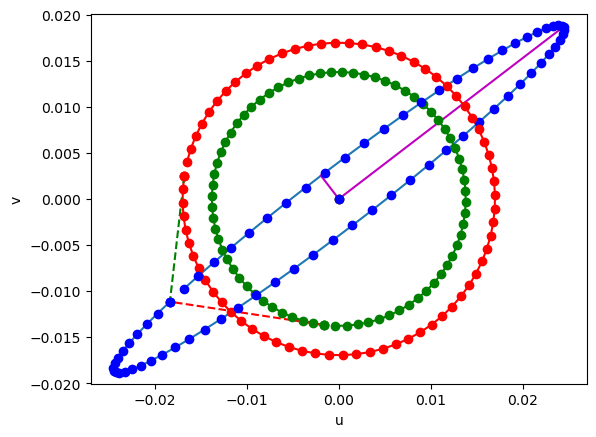

In [18]:
plot_ellipse("S1")

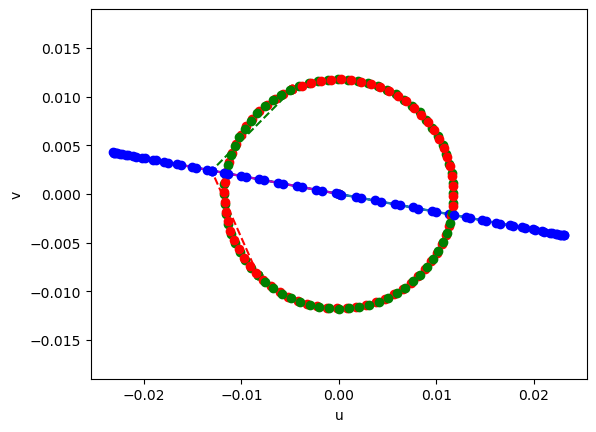

In [19]:
plot_ellipse("O1")

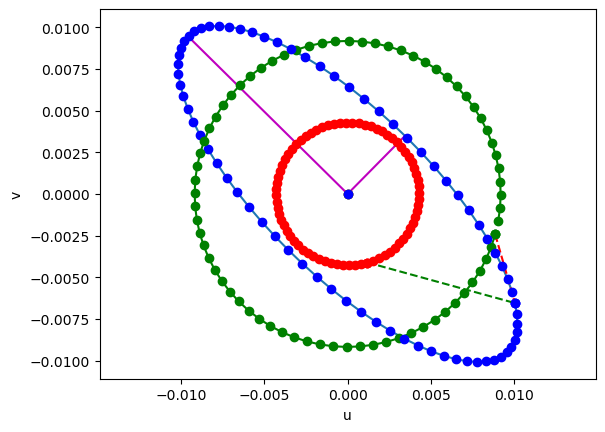

In [20]:
plot_ellipse("M4")